In [1]:
%load_ext autoreload
%autoreload 2
%load_ext snakeviz
%load_ext line_profiler

from coeditor.common import *
import os
from coeditor.model import RetrievalEditorModel, AttentionMode, DecodingArgs, EditCostModel, MultiRoundEvaluator, KeystrokeCostModel
from coeditor.service import EditPredictionService, ChangeDetector
from coeditor.c3problem import C3GeneratorCache, C3Problem, C3ProblemTokenizer

os.chdir(proj_root())

In [2]:
# target_dir = proj_root() / "../SPOT-copy/"
target_dir = proj_root()
model_name = "coeditor-xl-c3-dropout-v1.6-resumed"
model_path = get_model_dir(True) / model_name
model = RetrievalEditorModel.load(model_path)
model.to("cuda:2")
pass

In [3]:
testset: list[C3Problem] = pickle_load(
    get_dataset_dir("xl")
    / "transformed"
    / "C3ProblemGenerator(VERSION=2.9)-C3ProblemChangeDropout(VERSION=1.3)"
)["test"]
len(testset)


39477

In [4]:
subset = list[C3Problem]()
for ex in tqdm(testset):
    ex = ex.restrict_span_changes()
    c = ex.span.get_change()
    if len(c.before) <= 6000 and len(c.after) <= 6000:
        subset.append(ex)


100%|██████████| 39477/39477 [00:59<00:00, 666.13it/s] 


In [5]:
cm = KeystrokeCostModel()
subset = subset[0:-1:10]
all_costs = pmap(
    cm.get_edit_gain,
    [ex.span.original.tolist() for ex in subset],
    [ex.span.delta for ex in subset],
)
scalar_stats(all_costs)

pmap: get_edit_gain: 100%|██████████| 3682/3682 [00:31<00:00, 116.39it/s]


{'mean': 101.70885388375882, 'median': 43.0, 'min': 0.0, 'max': 2399.0}

(array([729., 546., 426., 271., 251., 171., 154., 124.,  90.,  87.,  76.,
         52.,  51.,  62.,  37.,  36.,  47.,  39.,  32.,  30.,  22.,  25.,
         26.,  12.,  22.,  18.,  17.,  11.,  11.,  10.,  10.,   7.,   5.,
          8.,   8.,   4.,   7.,  10.,   9.,   6.]),
 array([  0. ,  12.5,  25. ,  37.5,  50. ,  62.5,  75. ,  87.5, 100. ,
        112.5, 125. , 137.5, 150. , 162.5, 175. , 187.5, 200. , 212.5,
        225. , 237.5, 250. , 262.5, 275. , 287.5, 300. , 312.5, 325. ,
        337.5, 350. , 362.5, 375. , 387.5, 400. , 412.5, 425. , 437.5,
        450. , 462.5, 475. , 487.5, 500. ]),
 <BarContainer object of 40 artists>)

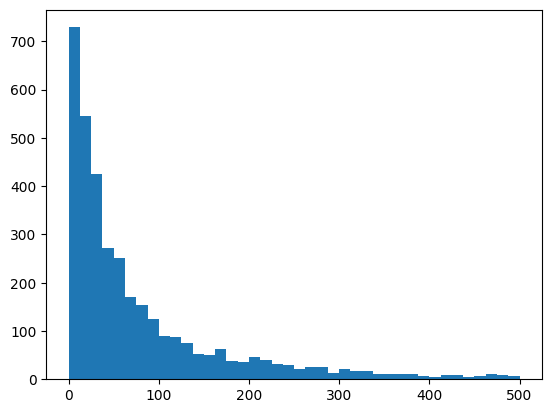

In [6]:
# plot a histogram of the costs
import matplotlib.pyplot as plt

plt.hist(all_costs, bins=40, range=(0, 500))


In [7]:
subset = [ex for i, ex in enumerate(subset) if 50 <= all_costs[i] <= 500]
len(subset)


1587

cm = EditCostModel()
%timeit -n 1 -r 3 all_costs = [cm.get_edit_gain(ex.span.original.tolist(), ex.span.delta) for ex in tqdm(testset[:50])]

In [8]:
tokenizer = C3ProblemTokenizer(
    max_query_tks=1024,
    max_ref_tks=1024,
    max_output_tks=512,
    max_ref_tks_sum=1024 * 12,
)
dec_args = DecodingArgs(do_sample=False, num_beams=1, length_penalty=0.0)

# %lprun -f -u 0.001 RetrievalEditorModel.multi_round_edit_gain
evaluator = MultiRoundEvaluator(model, tokenizer, dec_args, strategy="most_uncertain")
multi_stats = [
    evaluator.multi_round_edit_gain(ex, print_steps=False)
    for ex in tqdm(subset, smoothing=0.0)
]


100%|██████████| 1587/1587 [1:36:43<00:00,  3.66s/it]


In [9]:
for cm in evaluator.cost_models:
    cm_name = cm.name
    print(SEP)
    print("Cost model:", cm_name)
    stats = [s[cm_name] for s in multi_stats]

    keys = ["label_edit_gain", "first_edit_gain", "total_edit_gain", "rounds"]
    mean_stats = {k: scalar_stats([getattr(s, k) for s in stats]) for k in keys}   
    pretty_print_dict(mean_stats)

    print(f"For all edits (n={len(stats)}):")
    label_sum = sum(s.label_edit_gain for s in stats)
    single_sum = sum(s.first_edit_gain for s in stats)
    multi_sum = sum(s.total_edit_gain for s in stats)
    print(f"Single-round Gain ratio: {single_sum / label_sum:.2%}")
    print(f"Multi-round Gain ratio: {multi_sum / label_sum:.2%}")

    # big_stats = [s for s in stats if 100 <= s.label_edit_gain]
    # print(f"For big edits (n={len(big_stats)}):")
    # label_sum = sum(s.label_edit_gain for s in big_stats)
    # single_sum = sum(s.first_edit_gain for s in big_stats)
    # multi_sum = sum(s.total_edit_gain for s in big_stats)
    # print(f"Single-round Gain ratio: {single_sum / label_sum:.2%}")
    # print(f"Multi-round Gain ratio: {multi_sum / label_sum:.2%}")

--------------------------------------------------------------------------------
Cost model: keystrokes
label_edit_gain: {mean: 149.09, median: 113, min: 50, max: 498}
first_edit_gain: {mean: 44.772, median: 16, min: 0, max: 467}
total_edit_gain: {mean: 63.585, median: 51, min: -155, max: 459}
rounds: {mean: 3.1638, median: 3, min: 1, max: 8}
For all edits (n=1587):
Single-round Gain ratio: 30.03%
Multi-round Gain ratio: 42.65%
--------------------------------------------------------------------------------
Cost model: diff-lines
label_edit_gain: {mean: 66.928, median: 53, min: 8, max: 631}
first_edit_gain: {mean: 23.029, median: 9, min: 0, max: 452}
total_edit_gain: {mean: 36.101, median: 26, min: 0, max: 530}
rounds: {mean: 3.1638, median: 3, min: 1, max: 8}
For all edits (n=1587):
Single-round Gain ratio: 34.41%
Multi-round Gain ratio: 53.94%
--------------------------------------------------------------------------------
Cost model: levenshtein
label_edit_gain: {mean: 157.9, median

In [3]:
# find the first index where the edit gain is less than 0
ex_id = random.choice([i for i, s in enumerate(multi_stats) if s["levenshtein"].rounds > 1 and s["levenshtein"].label_edit_gain > s["levenshtein"].total_edit_gain > 90])
ex = subset[ex_id]
ex.print()

NameError: name 'random' is not defined